In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [5]:
from solver import deasolver

In [6]:
results = []
df_imp = pd.DataFrame()

In [7]:
path = "Data/RealData/eGrid/recent/"

In [8]:
df = pd.read_excel(path + "egrid2020_data.xlsx", sheet_name="PLNT20", usecols="D, W, AB, AL, AN, AP, AR, AS, AT, AU").drop(0)

In [9]:
# os.listdir(path)

In [31]:
# df= pd.DataFrame()
# i=0
# for file in os.listdir(path):
#     if os.path.splitext(file)[1] == ".xlsx" and not "copy" in file:
#         df_temp = pd.read_excel(path + file, sheet_name=3, usecols="D, W, AB, AL, AN, AP, AR, AS, AT, AU").drop(0)
#         df = pd.concat([df, df_temp], ignore_index=True)
#         print(i)

0
0
0


In [10]:
df.set_index("Plant name", inplace=True)
df.dropna(inplace=True)

In [11]:
df = df[(df!=0).all(axis=1)]

In [12]:
for col in df.columns:
    df[col] = df[col].astype("float")

In [13]:
def find_outliers(df_in, col_name):
    Q1 = df_in[col_name].quantile(0.25)
    Q3 = df_in[col_name].quantile(0.75)
    IQR = Q3-Q1
    fence_low  = Q1-1.5*IQR
    fence_high = Q3+1.5*IQR
    outlier_indexes=df_in[(df_in[col_name] <= fence_low) | (df_in[col_name] >= fence_high)].index.tolist()
    return outlier_indexes

bad_indexes=[]
for col in df.columns:
    if df[col].dtype in ["int64", "float64"]:
        outlierindexes= find_outliers(df, col)
        bad_indexes.extend(outlierindexes)
bad_index_list = list(set(bad_indexes))
print(f"All Bad indexes:{bad_index_list[:5]}")  

All Bad indexes:['Stored Solar Fitchburg, LLC', 'Scrubgrass Generating Plant', 'McManus', 'Ackerman Combined Cycle Plant', 'Sikeston']


In [14]:
len(bad_index_list)

1018

In [15]:
df.drop(bad_index_list, inplace=True)

In [16]:
df.shape

(1736, 9)

In [17]:
df.corr()

,Number of generators,Plant nameplate capacity (MW),Plant total annual heat input (MMBtu),Plant annual net generation (MWh),Plant annual NOx emissions (tons),Plant annual SO2 emissions (tons),Plant annual CO2 emissions (tons),Plant annual CH4 emissions (lbs),Plant annual N2O emissions (lbs)
Number of generators,1.000000,0.181480,-0.003909,-0.022683,0.038609,0.021377,-0.001940,-0.059766,-0.065294
Plant nameplate capacity (MW),0.181480,1.000000,0.637682,0.549069,0.223820,0.114721,0.632469,0.343939,0.271035
Plant total annual heat input (MMBtu),-0.003909,0.637682,1.000000,0.947835,0.403749,0.182435,0.990138,0.587933,0.478235
Plant annual net generation (MWh),-0.022683,0.549069,0.947835,1.000000,0.396695,0.189016,0.944962,0.580786,0.477823
Plant annual NOx emissions (tons),0.038609,0.223820,0.403749,0.396695,1.000000,0.221986,0.397671,0.276437,0.241109
Plant annual SO2 emissions (tons),0.021377,0.114721,0.182435,0.189016,0.221986,1.000000,0.170689,0.466099,0.489287
Plant annual CO2 emissions (tons),-0.001940,0.632469,0.990138,0.944962,0.397671,0.170689,1.000000,0.556909,0.446684
Plant annual CH4 emissions (lbs),-0.059766,0.343939,0.587933,0.580786,0.276437,0.466099,0.556909,1.000000,0.987415
Plant annual N2O emissions (lbs),-0.065294,0.271035,0.478235,0.477823,0.241109,0.489287,0.446684,0.987415,1.000000


In [18]:
df.index.name = None

In [19]:
df

,Number of generators,Plant nameplate capacity (MW),Plant total annual heat input (MMBtu),Plant annual net generation (MWh),Plant annual NOx emissions (tons),Plant annual SO2 emissions (tons),Plant annual CO2 emissions (tons),Plant annual CH4 emissions (lbs),Plant annual N2O emissions (lbs)
Ambler,4.0,1.5,11554.999,1212.000,19.200,1.675,943.616,76.423,15.285
Anchorage 1,8.0,121.4,115024.996,7646.000,18.056,0.193,6724.603,262.106,27.488
Angoon,4.0,1.9,16506.999,1641.999,26.523,2.393,1348.008,109.175,21.835
Aniak,6.0,2.6,26541.000,2183.001,44.968,3.848,2167.415,175.539,35.108
Auke Bay,3.0,36.2,5298.000,-143.000,3.051,1.279,432.650,35.040,7.008
...,...,...,...,...,...,...,...,...,...
Hartzog,3.0,22.5,11058.999,615.999,1.842,0.018,646.338,24.381,2.438
Lake (WY),1.0,2.7,1335.000,100.000,2.134,0.194,109.020,8.830,1.766
Neil Simpson II (CT2),1.0,40.0,168852.656,15983.000,4.926,0.100,10034.400,375.908,37.591
Old Faithful,2.0,2.0,1299.000,85.000,2.078,0.188,106.080,8.591,1.718


In [20]:
df.columns

Index(['Number of generators', 'Plant nameplate capacity (MW)',
       'Plant total annual heat input (MMBtu)',
       'Plant annual net generation (MWh)',
       'Plant annual NOx emissions (tons)',
       'Plant annual SO2 emissions (tons)',
       'Plant annual CO2 emissions (tons)', 'Plant annual CH4 emissions (lbs)',
       'Plant annual N2O emissions (lbs)'],
      dtype='object')

In [21]:
df.columns = ['Number of generators', 'Plant nameplate capacity (MW)',
       'Plant total annual heat input (MMBtu)',
       'Plant annual NOx emissions (tons)',
       'Plant annual SO2 emissions (tons)',
       'Plant annual CO2 emissions (tons)', 'Plant annual CH4 emissions (lbs)',
       'Plant annual N2O emissions (lbs)',
       'Plant annual net generation (MWh)']

In [22]:
df.columns = ["Output_" + col if "MWh" in col else "Input_" + col for col in df.columns]

In [23]:
df.to_excel(path + 'egrid2020_data_copy_1.xlsx')

In [14]:
df = pd.read_excel(path + 'egrid2020_data_copy_1.xlsx', index_col=0)
df

,Input_Number of generators,Input_Plant nameplate capacity (MW),Input_Plant total annual heat input (MMBtu),Input_Plant annual NOx emissions (tons),Input_Plant annual SO2 emissions (tons),Input_Plant annual CO2 emissions (tons),Input_Plant annual CH4 emissions (lbs),Input_Plant annual N2O emissions (lbs),Output_Plant annual net generation (MWh)
DMU 0001,4,1.5,11554.999,1212.000,19.200,1.675,943.616,76.423,15.285
DMU 0002,8,121.4,115024.996,7646.000,18.056,0.193,6724.603,262.106,27.488
DMU 0003,4,1.9,16506.999,1641.999,26.523,2.393,1348.008,109.175,21.835
DMU 0004,6,2.6,26541.000,2183.001,44.968,3.848,2167.415,175.539,35.108
DMU 0005,3,36.2,5298.000,-143.000,3.051,1.279,432.650,35.040,7.008
...,...,...,...,...,...,...,...,...,...
DMU 1729,3,22.5,11058.999,615.999,1.842,0.018,646.338,24.381,2.438
DMU 1730,1,2.7,1335.000,100.000,2.134,0.194,109.020,8.830,1.766
DMU 1731,1,40.0,168852.656,15983.000,4.926,0.100,10034.400,375.908,37.591
DMU 1732,2,2.0,1299.000,85.000,2.078,0.188,106.080,8.591,1.718


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1733 entries, DMU 0001 to DMU 1733
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Input_Number of generators                   1733 non-null   int64  
 1   Input_Plant nameplate capacity (MW)          1733 non-null   float64
 2   Input_Plant total annual heat input (MMBtu)  1733 non-null   float64
 3   Input_Plant annual NOx emissions (tons)      1733 non-null   float64
 4   Input_Plant annual SO2 emissions (tons)      1733 non-null   float64
 5   Input_Plant annual CO2 emissions (tons)      1733 non-null   float64
 6   Input_Plant annual CH4 emissions (lbs)       1733 non-null   float64
 7   Input_Plant annual N2O emissions (lbs)       1733 non-null   float64
 8   Output_Plant annual net generation (MWh)     1733 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 135.4+ KB


In [22]:
deasolver(inputfile = path + 'egrid2020_data_copy_1.xlsx', folder = "Data/RealData/eGrid/recent/", out_suffix1="_Sol")

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


100.0
Solution file saved outputfile


In [16]:
df_weights = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol.xlsx", index_col = 0).iloc[:, 1:]
df_weights

,Weight_Input_Number of generators,Weight_Input_Plant annual CH4 emissions (lbs),Weight_Input_Plant annual CO2 emissions (tons),Weight_Input_Plant annual N2O emissions (lbs),Weight_Input_Plant annual NOx emissions (tons),Weight_Input_Plant annual SO2 emissions (tons),Weight_Input_Plant nameplate capacity (MW),Weight_Input_Plant total annual heat input (MMBtu),Weight_Output_Plant annual net generation (MWh)
DMU 0001,0.000000,0.0,0.000000,0.007748,0.000282,0.000000,0.043676,0.000000,0.047188
DMU 0002,0.003882,0.0,0.168543,0.002937,0.000022,0.000000,0.000000,0.000000,0.009145
DMU 0003,0.000000,0.0,0.000000,0.005563,0.000203,0.000000,0.031361,0.000000,0.033883
DMU 0004,0.000000,0.0,0.000000,0.003707,0.000135,0.000000,0.020895,0.000000,0.022575
DMU 0005,0.106627,0.0,0.000000,0.012964,0.000261,0.000000,0.000000,0.000050,0.077712
...,...,...,...,...,...,...,...,...,...
DMU 1729,0.000776,0.0,0.546873,0.038826,0.000067,0.000000,0.000000,0.000000,0.095109
DMU 1730,0.000000,0.0,0.000000,0.047312,0.000786,0.000000,0.043375,0.000290,0.306928
DMU 1731,0.000000,0.0,0.289059,0.001763,0.000000,0.062621,0.000000,0.000000,0.009504
DMU 1732,0.000000,0.0,0.000000,0.050541,0.000839,0.000000,0.046335,0.000309,0.327873


In [17]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_Number of generators                     1065
Weight_Input_Plant annual CH4 emissions (lbs)         1677
Weight_Input_Plant annual CO2 emissions (tons)         982
Weight_Input_Plant annual N2O emissions (lbs)           16
Weight_Input_Plant annual NOx emissions (tons)         721
Weight_Input_Plant annual SO2 emissions (tons)        1219
Weight_Input_Plant nameplate capacity (MW)            1153
Weight_Input_Plant total annual heat input (MMBtu)    1196
Weight_Output_Plant annual net generation (MWh)          0
dtype: int64

### ML

In [18]:
X = df.iloc[:,:-1]
X.head()

,Input_Number of generators,Input_Plant nameplate capacity (MW),Input_Plant total annual heat input (MMBtu),Input_Plant annual NOx emissions (tons),Input_Plant annual SO2 emissions (tons),Input_Plant annual CO2 emissions (tons),Input_Plant annual CH4 emissions (lbs),Input_Plant annual N2O emissions (lbs)
DMU 0001,4,1.5,11554.999,1212.000,19.200,1.675,943.616,76.423
DMU 0002,8,121.4,115024.996,7646.000,18.056,0.193,6724.603,262.106
DMU 0003,4,1.9,16506.999,1641.999,26.523,2.393,1348.008,109.175
DMU 0004,6,2.6,26541.000,2183.001,44.968,3.848,2167.415,175.539
DMU 0005,3,36.2,5298.000,-143.000,3.051,1.279,432.650,35.040


In [19]:
y = df.iloc[:,-1:]
y.head()

,Output_Plant annual net generation (MWh)
DMU 0001,15.285
DMU 0002,27.488
DMU 0003,21.835
DMU 0004,35.108
DMU 0005,7.008


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [22]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -9856.804480569948
neg_root_mean_squared_error: -97.812388982155
r2: 0.9781446803255811


In [23]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [24]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [25]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [26]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-94.53945887235345
{'gradientboostingregressor__subsample': 0.5, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           min_samples_split=30,
                                           n_estimators=2000, random_state=42,
                                           subsample=0.5))])
r2: 0.9771663596300371


In [27]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.98])

In [28]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
7,Input_Plant annual N2O emissions (lbs),0.982515
2,Input_Plant total annual heat input (MMBtu),0.005400
6,Input_Plant annual CH4 emissions (lbs),0.005132
5,Input_Plant annual CO2 emissions (tons),0.004288
3,Input_Plant annual NOx emissions (tons),0.001282
1,Input_Plant nameplate capacity (MW),0.001056
4,Input_Plant annual SO2 emissions (tons),0.000203
0,Input_Number of generators,0.000124


In [29]:
input_imp = list(df_gb["Feature Name"].values)
results.append((0, grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

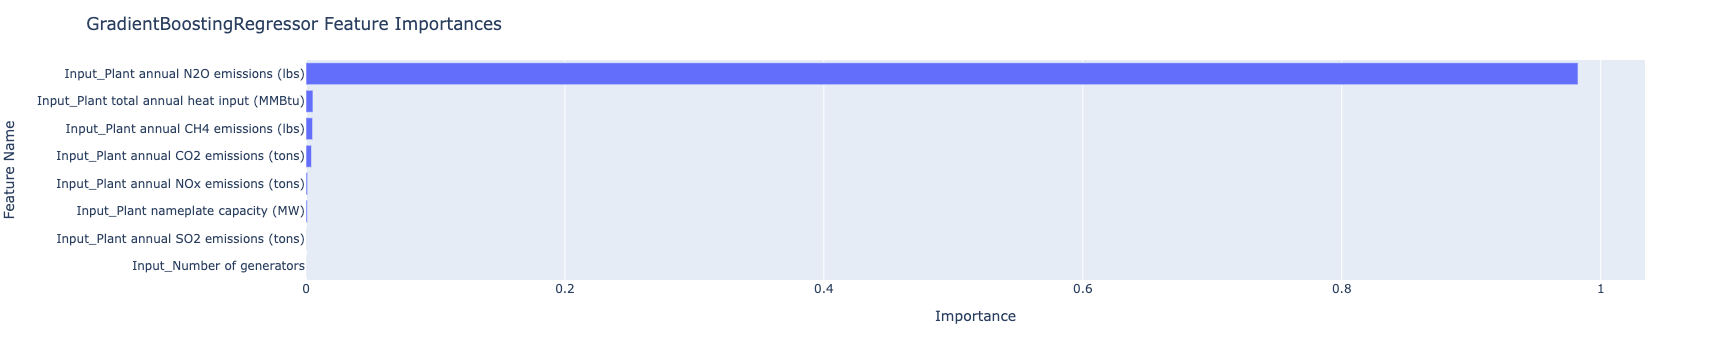

In [31]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=600,
    height=300,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [32]:
df_gb

,Feature Name,Importance
7,Input_Plant annual N2O emissions (lbs),0.982515
2,Input_Plant total annual heat input (MMBtu),0.005400
6,Input_Plant annual CH4 emissions (lbs),0.005132
5,Input_Plant annual CO2 emissions (tons),0.004288
3,Input_Plant annual NOx emissions (tons),0.001282
1,Input_Plant nameplate capacity (MW),0.001056
4,Input_Plant annual SO2 emissions (tons),0.000203
0,Input_Number of generators,0.000124


In [33]:
df_zero.index = ["_".join(f.split("_")[1:]) for f in df_zero.index]

In [34]:
df_zero

Input_Number of generators                     1065
Input_Plant annual CH4 emissions (lbs)         1677
Input_Plant annual CO2 emissions (tons)         982
Input_Plant annual N2O emissions (lbs)           16
Input_Plant annual NOx emissions (tons)         721
Input_Plant annual SO2 emissions (tons)        1219
Input_Plant nameplate capacity (MW)            1153
Input_Plant total annual heat input (MMBtu)    1196
Output_Plant annual net generation (MWh)          0
dtype: int64

In [35]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Input_Plant annual N2O emissions (lbs),0.982515,Input_Plant annual N2O emissions (lbs),16
1,Input_Plant total annual heat input (MMBtu),0.005400,Input_Plant total annual heat input (MMBtu),1196
2,Input_Plant annual CH4 emissions (lbs),0.005132,Input_Plant annual CH4 emissions (lbs),1677
3,Input_Plant annual CO2 emissions (tons),0.004288,Input_Plant annual CO2 emissions (tons),982
4,Input_Plant annual NOx emissions (tons),0.001282,Input_Plant annual NOx emissions (tons),721
5,Input_Plant nameplate capacity (MW),0.001056,Input_Plant nameplate capacity (MW),1153
6,Input_Plant annual SO2 emissions (tons),0.000203,Input_Plant annual SO2 emissions (tons),1219
7,Input_Number of generators,0.000124,Input_Number of generators,1065


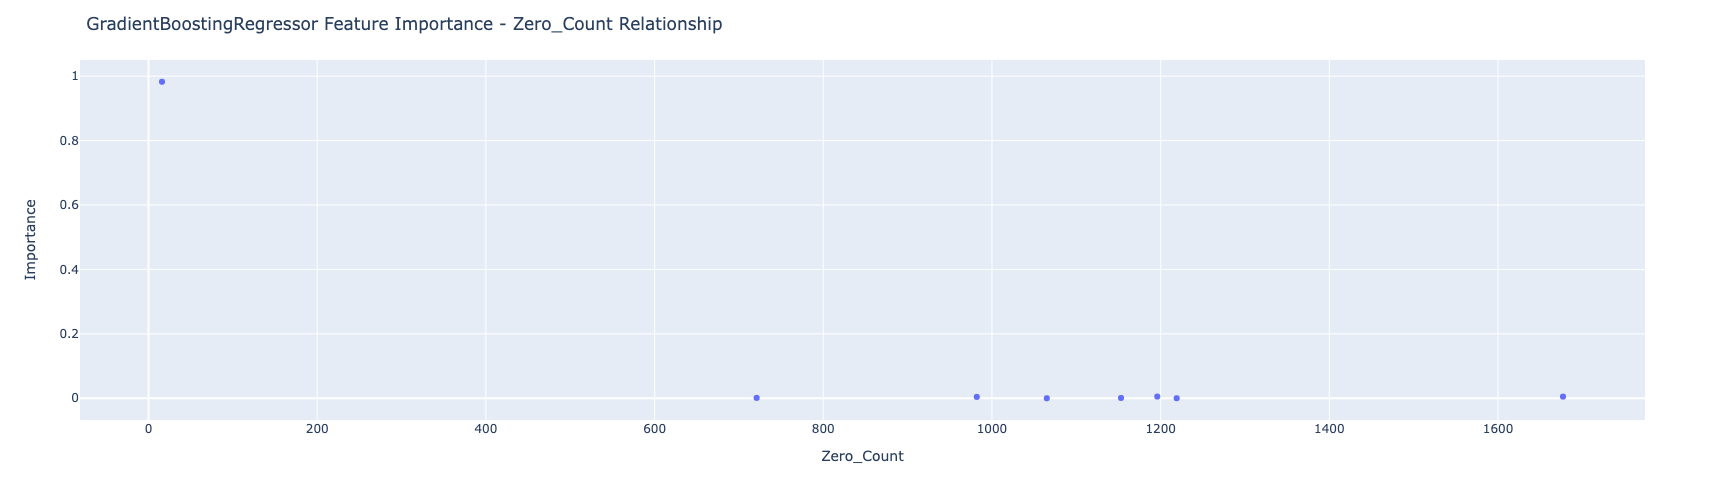

In [36]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

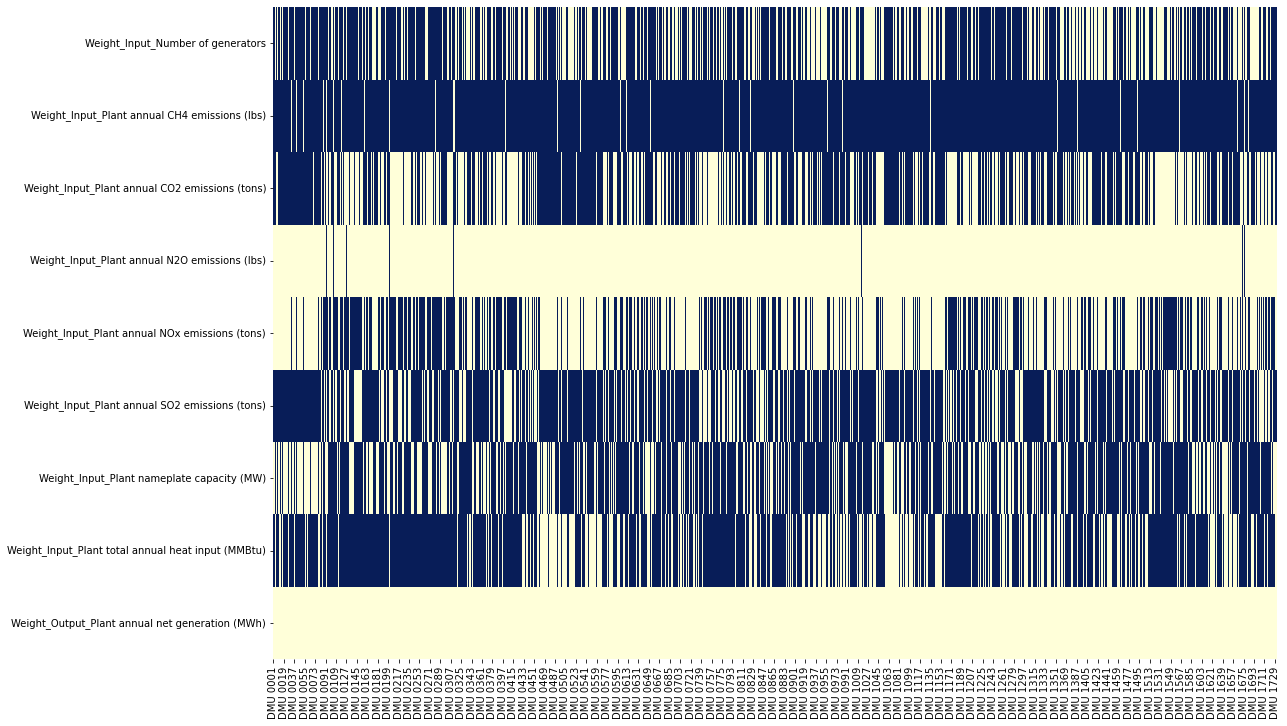

In [37]:
plt.figure(figsize=(18,12))
sns.heatmap(df_weights.eq(0).transpose(),
        cmap="YlGnBu",
        cbar=False,
        cbar_kws={'label': 'Zero Values'});

In [38]:
results 

[(0,
  'gradientboostingregressor',
  ['Input_Plant annual N2O emissions (lbs)',
   'Input_Plant total annual heat input (MMBtu)',
   'Input_Plant annual CH4 emissions (lbs)',
   'Input_Plant annual CO2 emissions (tons)',
   'Input_Plant annual NOx emissions (tons)',
   'Input_Plant nameplate capacity (MW)',
   'Input_Plant annual SO2 emissions (tons)',
   'Input_Number of generators'],
  {'r2': 0.9771663596300371,
   'neg_root_mean_squared_error': -94.53945887235345})]

In [39]:
deasolver(inputfile="Data/RealData/eGrid/recent/egrid2020_data_copy_1.xlsx", folder = "Data/RealData/eGrid/recent/", out_suffix1="_Sol_1", input_imp = results[0])

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


100.0
Solution file saved outputfile


In [40]:
df_weights_1 = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol_1.xlsx", index_col = 0).iloc[:, 1:]
df_weights_1

,Weight_Input_Number of generators,Weight_Input_Plant annual CH4 emissions (lbs),Weight_Input_Plant annual CO2 emissions (tons),Weight_Input_Plant annual N2O emissions (lbs),Weight_Input_Plant annual NOx emissions (tons),Weight_Input_Plant annual SO2 emissions (tons),Weight_Input_Plant nameplate capacity (MW),Weight_Input_Plant total annual heat input (MMBtu),Weight_Output_Plant annual net generation (MWh)
DMU 0001,0.000003,2.930752e-06,2.930752e-06,0.003678,2.930752e-06,0.000003,0.000003,6.166599e-05,0.032120
DMU 0002,0.000000,1.364793e-07,1.364793e-07,0.003748,1.364793e-07,0.000000,0.000000,1.364793e-07,0.008496
DMU 0003,0.000002,2.051931e-06,2.051931e-06,0.002575,2.051931e-06,0.000002,0.000002,4.317471e-05,0.022489
DMU 0004,0.000001,1.276927e-06,1.276927e-06,0.001602,1.276927e-06,0.000001,0.000001,2.686783e-05,0.013995
DMU 0005,0.000006,6.419392e-06,6.419392e-06,0.008055,6.419392e-06,0.000006,0.000006,1.350705e-04,0.070355
...,...,...,...,...,...,...,...,...,...
DMU 1729,0.000000,1.466597e-06,1.466597e-06,0.040274,1.466597e-06,0.000000,0.000000,1.466597e-06,0.091294
DMU 1730,0.000025,2.539036e-05,2.539036e-05,0.031861,2.539036e-05,0.000025,0.000025,5.342390e-04,0.278271
DMU 1731,0.000000,9.507764e-08,9.507764e-08,0.002611,9.507764e-08,0.000000,0.000000,9.507764e-08,0.005918
DMU 1732,0.000026,2.610289e-05,2.610289e-05,0.032755,2.610289e-05,0.000026,0.000026,5.492312e-04,0.286080


In [41]:
df_es = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol.xlsx", index_col = 0).iloc[:, :1]
df_es_1 = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_1_Sol_1.xlsx", index_col = 0).iloc[:, :1]

In [42]:
es = (df_es.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es}")

count of efficient units : 22


In [43]:
es_1 = (df_es_1.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es_1}")

count of efficient units : 2


In [44]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_Number of generators                     1065
Weight_Input_Plant annual CH4 emissions (lbs)         1677
Weight_Input_Plant annual CO2 emissions (tons)         982
Weight_Input_Plant annual N2O emissions (lbs)           16
Weight_Input_Plant annual NOx emissions (tons)         721
Weight_Input_Plant annual SO2 emissions (tons)        1219
Weight_Input_Plant nameplate capacity (MW)            1153
Weight_Input_Plant total annual heat input (MMBtu)    1196
Weight_Output_Plant annual net generation (MWh)          0
dtype: int64

In [45]:
df_zero =(df_weights_1==0).sum()
df_zero

Weight_Input_Number of generators                     823
Weight_Input_Plant annual CH4 emissions (lbs)         526
Weight_Input_Plant annual CO2 emissions (tons)        523
Weight_Input_Plant annual N2O emissions (lbs)           0
Weight_Input_Plant annual NOx emissions (tons)         54
Weight_Input_Plant annual SO2 emissions (tons)        807
Weight_Input_Plant nameplate capacity (MW)            654
Weight_Input_Plant total annual heat input (MMBtu)    117
Weight_Output_Plant annual net generation (MWh)         0
dtype: int64

In [46]:
df_es

,Efficiency_Scores
DMU 0001,0.721272
DMU 0002,0.251382
DMU 0003,0.739827
DMU 0004,0.792566
DMU 0005,0.544606
...,...
DMU 1729,0.231875
DMU 1730,0.542035
DMU 1731,0.357247
DMU 1732,0.563285


In [47]:
df_es_1

,Efficiency_Scores
DMU 0001,0.490957
DMU 0002,0.233529
DMU 0003,0.491038
DMU 0004,0.491328
DMU 0005,0.493046
...,...
DMU 1729,0.222575
DMU 1730,0.491427
DMU 1731,0.222481
DMU 1732,0.491486


In [51]:
df_res = df_es.join(df_es_1, lsuffix = "_Basic", rsuffix="_with_ML")

In [52]:
df_res["Diff"] = df_res["Efficiency_Scores_Basic"]  - df_res["Efficiency_Scores_with_ML"]
df_res["Diff_Perc"] = (df_res["Diff"] / df_res["Efficiency_Scores_Basic"]) * 100 
df_res["Diff_Perc < 10"] = np.abs(df_res["Diff_Perc"]) < 10  
df_res = df_res.round(4)
df_res

,Efficiency_Scores_Basic,Efficiency_Scores_with_ML,Diff,Diff_Perc,Diff_Perc < 10
DMU 0001,0.7213,0.4910,0.2303,31.9317,False
DMU 0002,0.2514,0.2335,0.0179,7.1017,True
DMU 0003,0.7398,0.4910,0.2488,33.6280,False
DMU 0004,0.7926,0.4913,0.3012,38.0080,False
DMU 0005,0.5446,0.4930,0.0516,9.4675,True
...,...,...,...,...,...
DMU 1729,0.2319,0.2226,0.0093,4.0109,True
DMU 1730,0.5420,0.4914,0.0506,9.3367,True
DMU 1731,0.3572,0.2225,0.1348,37.7233,False
DMU 1732,0.5633,0.4915,0.0718,12.7466,False


In [55]:
blue = df_res["Diff_Perc < 10"].sum()
print("blue : ", blue)
red = len(df_res["Diff_Perc < 10"]) - (df_res["Diff_Perc < 10"].sum())
print("red : ", red)

blue :  886
red :  847


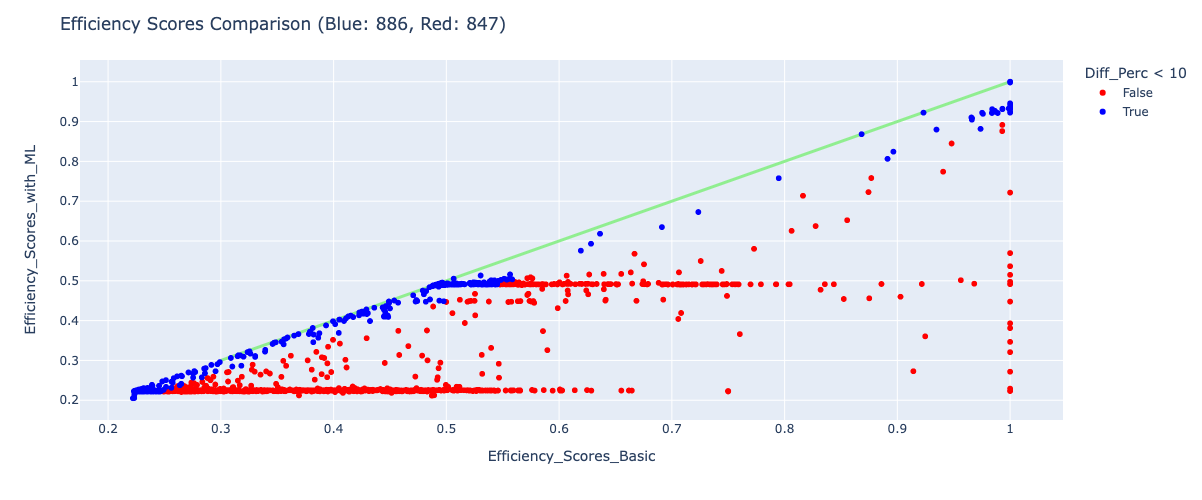

In [56]:
fig = px.scatter(df_res, x="Efficiency_Scores_Basic", y="Efficiency_Scores_with_ML", color = "Diff_Perc < 10", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Efficiency_Scores_Basic", "Efficiency_Scores_with_ML", "Diff_Perc"] + [df_res.index])

fig.add_traces(
    list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
)

fig.update_traces(line_color='lightgreen', line_width=3)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Efficiency Scores Comparison (Blue: {blue}, Red: {red})",
)

fig.show()